In [1]:
import tensorflow as tf
import talib
from pandas import DataFrame, read_csv, concat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow_probability import distributions as tfd
from tensorflow.keras import layers
from tensorflow_probability import layers as tfl
from tensorflow_probability import vi as vi
from tensorflow import keras
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.regularizers import l2
from sklearn.feature_selection import mutual_info_regression
from scipy.fft import fft
import emd

In [2]:
def get_emd(signal):
    imfs = emd.sift.sift(signal.values)
    
    t = [i for i in range(len(signal))]
    N = imfs.shape[1]
    fig, axs = plt.subplots(N + 1, 1, figsize=(15,9))
    axs[0].plot(t, signal)
    axs[0].set_title('Original Signal')
    for n in range(N):
        axs[n+1].plot(t, imfs[:,n])
        axs[n+1].set_title(f'IMF {n}')
    
    return imfs

def phase_spectrum(imfs):
    imfs_p = []
    N = imfs.shape[1]
    fig, axs = plt.subplots(N, 1, figsize=(15,9))
    for i in range(N):
        trans = fft(imfs[:,i])
        imf_p = np.arctan(trans.imag / trans.real)
        
        imfs_p.append(imf_p)
        
        axs[i].plot(imf_p, 'o')
        axs[i].set_title(f'IMF {i}')
        
    return imfs_p

def phase_mi(phases):
    mis = []
    for i in range(len(phases)-1):
        mis.append(mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0])
    print(mis)
    return np.array(mis)

def divide_signal(signal, imfs, mis, cutoff=0.05):
    cut_point = np.where(mis > cutoff)[0][0]
    stochastic_component = np.sum(imfs[:,:cut_point], axis=1)
    deterministic_component = np.sum(imfs[:,cut_point:], axis=1)
    
    t = [i for i in range(len(signal))]
    
    fig, axs = plt.subplots(3, 1, figsize=(15,12))
    axs[0].plot(t, signal.values)
    axs[0].set_title('Original Signal')
    
    axs[1].plot(t, stochastic_component)
    axs[1].set_title('Stochastic Component')
    
    axs[2].plot(t, deterministic_component)
    axs[2].set_title('Deterministic Component')
    
    return stochastic_component, deterministic_component

In [4]:
data = read_csv('btc_hourly.csv', parse_dates = ['timestamp'], usecols = ['timestamp', 'c']).fillna(method='ffill')
start_time = '2017-01-01 00:00:00'
split_time = '2021-02-01 00:00:00'
end_time = '2021-09-01 00:00:00'
data = data[(data['timestamp'] >= start_time) & (data['timestamp'] < end_time)]
start_index = data.index[data['timestamp'] == start_time].tolist()[0]
split_index = data.index[data['timestamp'] == split_time].tolist()[0]

[0.0008826654891356256, 0.003115106423010161, 0.5278796418980978, 4.7469971269873925, 6.541215185054879, 7.670420258833292, 8.980666640951029, 9.033810893212651, 9.073600085041248]


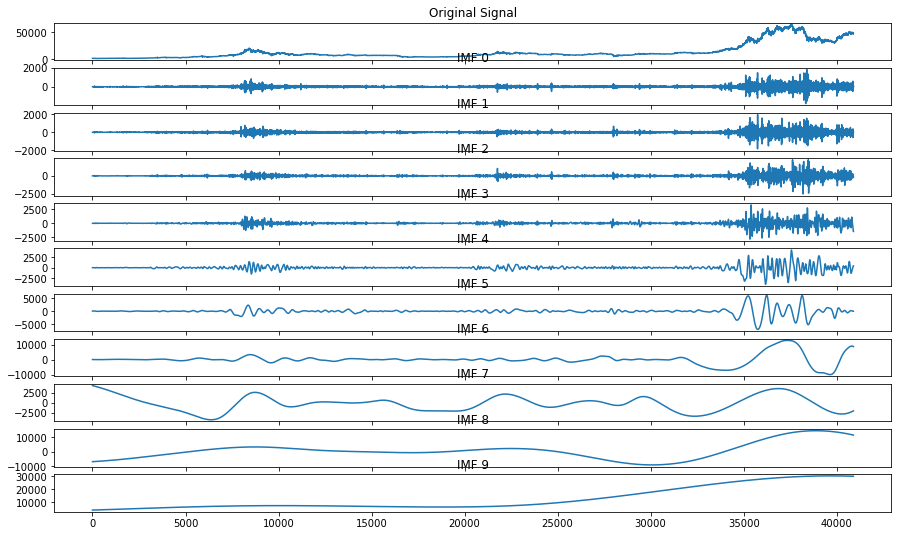

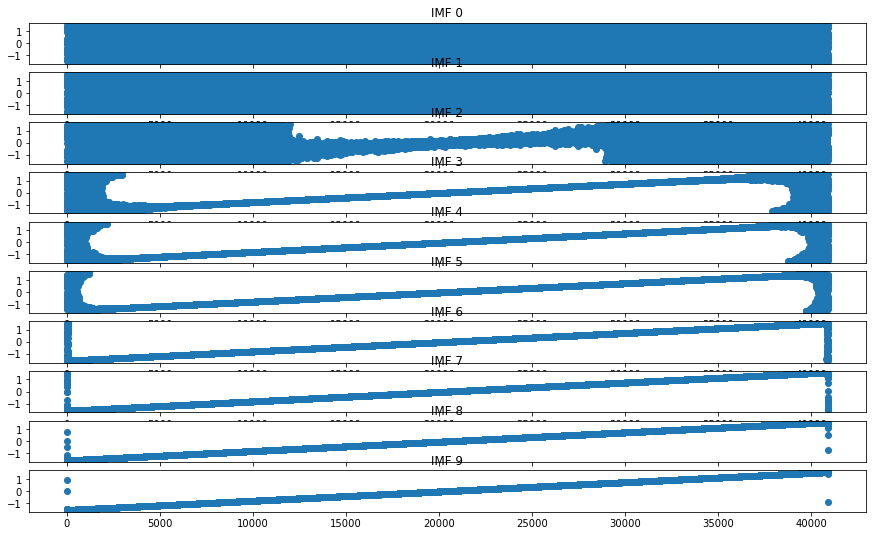

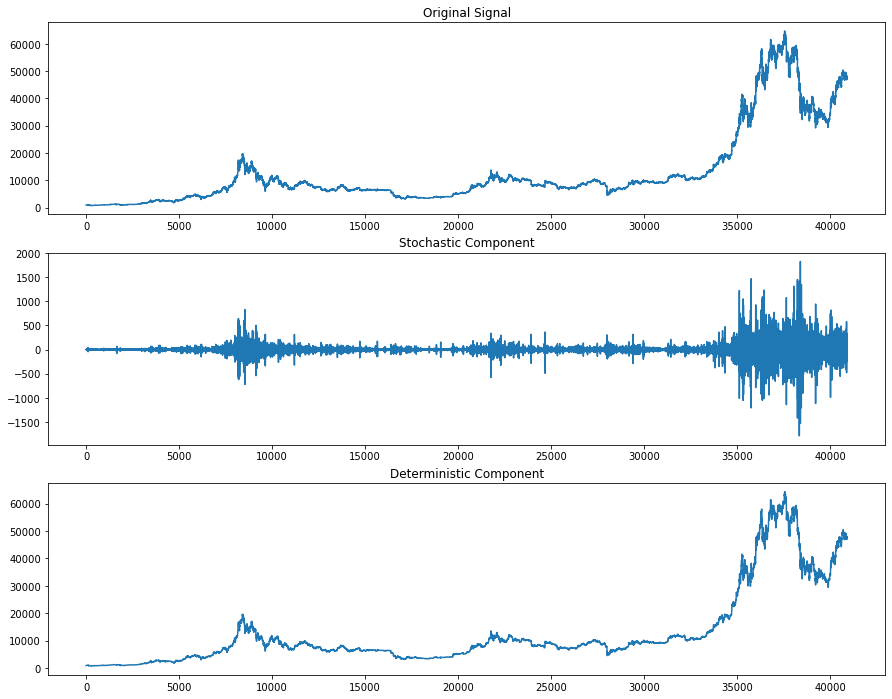

In [31]:
imfs = get_emd(data['c'])
mis = phase_mi(phase_spectrum(imfs))
data['d'] = divide_signal(data['c'], imfs, mis, 0.001)[1]

In [47]:
sma_24 = talib.SMA(data['d'], timeperiod=24)
sma_42 = talib.SMA(data['d'], timeperiod=42)
sma_72 = talib.SMA(data['d'], timeperiod=72)
sma_125 = talib.SMA(data['d'], timeperiod=125)
ema_36 = talib.EMA(data['d'], timeperiod=36)
ema_95 = talib.EMA(data['d'], timeperiod=95)
ema_184 = talib.EMA(data['d'], timeperiod=184)
macd = talib.MACD(data['d'], signalperiod=24)[0]
mom = talib.MOM(data['d'], timeperiod=24)
rsi = talib.RSI(data['d'], timeperiod=24)
price = data['d']
label = data['c']

features = DataFrame()
features['sma_24'] = sma_24
features['sma_42'] = sma_42
features['sma_72'] = sma_72
features['sma_125'] = sma_125
features['ema_36'] = ema_36
features['ema_95'] = ema_95
features['ema_184'] = ema_184
features['macd'] = macd
features['rsi'] = rsi
features['mom'] = mom
features['price'] = price
features['label'] = label
features['y'] = features['label'].diff()
features = features.dropna()
labels = features['label'].values
prices = features['price'].values
features = features.drop(columns=['label'])

In [7]:
def to_supervised(data, n_input=1, n_out=2):
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input + 1
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, :]
			X.append(x_input)
			y.append(data[in_end:out_end, -1])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [48]:
scaler = StandardScaler()
scaled = scaler.fit(features).transform(features)

In [74]:
n = 3
series = series_to_supervised(scaled, n, 2)
dropColumns = []
for i in range(scaled.shape[1]-1):
    dropColumns.append('var{}(t+{})'.format(i+1,1))
for i in range(n):
    dropColumns.append('var{}(t-{})'.format(scaled.shape[1],i+1))
dropColumns.append('var{}(t)'.format(scaled.shape[1]))
reframed = series.drop(columns=dropColumns)
#reframed = series

split = int(0.7*scaled.shape[0])
#split = split_index-start_index-timerange-n
train_X, test_X = reframed.values[:split,:-1], reframed.values[split:,:-1]
train_y, test_y = reframed.values[:split,-1], reframed.values[split:,-1]

In [50]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t+1)
1,-0.852311,-0.853823,-0.852094,-0.847431,-0.852584,-0.850976,-0.847975,-0.013891,-0.309518,-0.015273,...,-0.852161,-0.847496,-0.852609,-0.851024,-0.848037,-0.020912,-0.373838,-0.023024,-0.852929,0.014962
2,-0.852287,-0.853802,-0.852161,-0.847496,-0.852609,-0.851024,-0.848037,-0.020912,-0.373838,-0.023024,...,-0.852235,-0.847562,-0.852633,-0.851071,-0.848099,-0.026707,-0.376958,-0.023008,-0.852939,-0.006969
3,-0.852263,-0.853773,-0.852235,-0.847562,-0.852633,-0.851071,-0.848099,-0.026707,-0.376958,-0.023008,...,-0.852308,-0.847625,-0.852646,-0.851113,-0.848157,-0.030374,-0.310431,-0.016513,-0.852758,0.006165
4,-0.852222,-0.853723,-0.852308,-0.847625,-0.852646,-0.851113,-0.848157,-0.030374,-0.310431,-0.016513,...,-0.852371,-0.847686,-0.852648,-0.851150,-0.848214,-0.032282,-0.240797,-0.009676,-0.852569,0.015913
5,-0.852165,-0.853645,-0.852371,-0.847686,-0.852648,-0.851150,-0.848214,-0.032282,-0.240797,-0.009676,...,-0.852424,-0.847745,-0.852643,-0.851184,-0.848268,-0.033179,-0.195664,-0.006977,-0.852447,0.009035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40707,2.492930,2.511487,2.545098,2.549282,2.507047,2.540283,2.560047,-0.727405,-0.776282,-1.107519,...,2.543505,2.549400,2.505341,2.539147,2.559415,-0.761599,-0.782299,-1.159589,2.469543,-0.116362
40708,2.490108,2.509117,2.543505,2.549400,2.505341,2.539147,2.559415,-0.761599,-0.782299,-1.159589,...,2.541909,2.549501,2.503480,2.537938,2.558741,-0.806470,-0.842543,-1.207224,2.464987,-1.650822
40709,2.487166,2.506967,2.541909,2.549501,2.503480,2.537938,2.558741,-0.806470,-0.842543,-1.207224,...,2.540244,2.549580,2.501373,2.536621,2.558004,-0.869904,-0.925564,-1.196012,2.458574,-0.321494
40710,2.484253,2.504968,2.540244,2.549580,2.501373,2.536621,2.558004,-0.869904,-0.925564,-1.196012,...,2.538452,2.549644,2.499109,2.535227,2.557220,-0.939056,-0.988846,-1.067424,2.453567,0.808098


In [75]:
hidden_units = [4, 4]
train_size = train_X.shape[0]
D = train_X.shape[1]

In [45]:
len(test_y)/(len(train_y)+len(test_y))

0.29996806759843775

In [12]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfl.DistributionLambda(
                lambda t: tfd.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfl.VariableLayer(
                tfl.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfl.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [13]:
def create_bnn_model():
    inputs = layers.Input(shape=(D), dtype=tf.float32)
    feats = layers.BatchNormalization()(inputs)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        feats = tfl.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation='relu',
            activity_regularizer=l2(0.0001)
        )(feats)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(feats)
    outputs = tfl.IndependentNormal(1)(distribution_params)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [15]:
def run_experiment(model, train_dataset, test_dataset):

    model.compile(
        optimizer='adam',
        loss=negative_loglikelihood,
        metrics=['mse'],
    )

    print("Start training the model...")
    model.fit(x=train_dataset[0], y=train_dataset[1], epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(x=train_dataset[0], y=train_dataset[1], verbose=0)
    print(f"Train RMSE: {round(rmse, 4)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(x=test_dataset[0], y=test_dataset[1], verbose=0)
    print(f"Test RMSE: {round(rmse, 4)}")

In [76]:
num_epochs = 200
bnn_model = create_bnn_model()
run_experiment(bnn_model, (train_X, train_y), (test_X, test_y))

Start training the model...
Epoch 1/200
891/891 [==============================] - 9s 6ms/step - loss: 6.5245 - mse: 48.0274 - val_loss: 19.9923 - val_mse: 2225.7305
Epoch 2/200
891/891 [==============================] - 5s 6ms/step - loss: 2.5708 - mse: 36.1415 - val_loss: 14.4286 - val_mse: 1140.2485
Epoch 3/200
891/891 [==============================] - 5s 5ms/step - loss: 1.9811 - mse: 19.3685 - val_loss: 5.0389 - val_mse: 695.2341
Epoch 4/200
891/891 [==============================] - 4s 5ms/step - loss: 1.5767 - mse: 7.8751 - val_loss: 4.3610 - val_mse: 182.6290
Epoch 5/200
891/891 [==============================] - 4s 4ms/step - loss: 1.3485 - mse: 3.8748 - val_loss: 4.5014 - val_mse: 148.2768
Epoch 6/200
891/891 [==============================] - 4s 5ms/step - loss: 1.1286 - mse: 1.9350 - val_loss: 3.8201 - val_mse: 43.9477
Epoch 7/200
891/891 [==============================] - 4s 4ms/step - loss: 0.9595 - mse: 1.2304 - val_loss: 3.5894 - val_mse: 16.0390
Epoch 8/200
891/891 [=

891/891 [==============================] - 4s 4ms/step - loss: 0.0817 - mse: 0.4304 - val_loss: 2.1372 - val_mse: 38.8032
Epoch 122/200
891/891 [==============================] - 4s 5ms/step - loss: 0.1067 - mse: 0.4671 - val_loss: 2.1465 - val_mse: 35.9420
Epoch 123/200
891/891 [==============================] - 5s 6ms/step - loss: 0.0948 - mse: 0.4378 - val_loss: 2.1689 - val_mse: 38.7037
Epoch 124/200
891/891 [==============================] - 5s 6ms/step - loss: 0.0790 - mse: 0.4176 - val_loss: 2.2263 - val_mse: 41.2893
Epoch 125/200
891/891 [==============================] - 4s 5ms/step - loss: 0.0913 - mse: 0.4454 - val_loss: 2.2110 - val_mse: 40.9446
Epoch 126/200
891/891 [==============================] - 5s 5ms/step - loss: 0.1020 - mse: 0.4477 - val_loss: 2.1112 - val_mse: 32.7611
Epoch 127/200
891/891 [==============================] - 4s 4ms/step - loss: 0.0985 - mse: 0.4211 - val_loss: 2.1476 - val_mse: 36.3932
Epoch 128/200
891/891 [==============================] - 4s 4m

In [20]:
def compute_predictions(model, dataset, iterations=1000):
    predicted = []
    for _ in tqdm(range(iterations)):
        predicted.append(model(dataset).mean().numpy())
    predicted = np.concatenate(predicted, axis=1)
    
    return predicted
    #prediction_mean = np.mean(predicted, axis=1).tolist()
    #prediction_min = np.min(predicted, axis=1).tolist()
    #prediction_max = np.max(predicted, axis=1).tolist()
    #prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

In [77]:
predictions = compute_predictions(bnn_model, test_X)#, len(test_y))
prediction_means = np.mean(predictions, axis=1).tolist()
training = compute_predictions(bnn_model, train_X)#, len(test_y))
training_means = np.mean(training, axis=1).tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.26it/s]


In [22]:
def mape(actual, predicted):
    num = 0
    count = 0
    for a, p in zip(actual, predicted):
        num += abs(a-p)/a
        count += 1
    return (num*100)/count

In [78]:
precision = 0.01
z = 1.96 #95% confidence
pnum = round(((z*np.std(prediction_means))/precision)**2)
tnum = round(((z*np.std(training_means))/precision)**2)
pnum, tnum

(163, 4)

In [79]:
#Predicting exact price values
actualValues = np.array(features['label'][n+1:]).reshape(-1,1)
scalerCrypto = scaler.fit(actualValues)
predictedValues = scalerCrypto.inverse_transform(np.array(prediction_means).reshape(-1,1))
trainingValues = scalerCrypto.inverse_transform(np.array(training_means).reshape(-1,1))
actualValues = labels[n+1:]
trainingValues = np.reshape(trainingValues, trainingValues.shape[0])
predictedValues = np.reshape(predictedValues, predictedValues.shape[0])

KeyError: 'label'

In [80]:
#Predicting returns
actualValues = np.array(features['y'][n+1:]).reshape(-1,1)
scalerCrypto = scaler.fit(actualValues)
predictedValues = scalerCrypto.inverse_transform(np.array(prediction_means).reshape(-1,1))
trainingValues = scalerCrypto.inverse_transform(np.array(training_means).reshape(-1,1))
actualValues = labels[n+1:]
trainingValues = np.add(np.reshape(trainingValues, trainingValues.shape[0]), prices[n:-1][:len(trainingValues)])
predictedValues = np.add(np.reshape(predictedValues, predictedValues.shape[0]), prices[n:-1][len(trainingValues):])

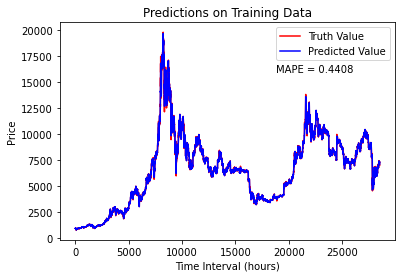

In [81]:
plt.plot(actualValues[:len(trainingValues)], color = 'red', label = 'Truth Value')
plt.plot(trainingValues, color = 'blue', label = 'Predicted Value')
plt.text(18800,15900,'MAPE = '+str(round(mape(actualValues[:len(trainingValues)], trainingValues),4)))
plt.title('Predictions on Training Data')
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

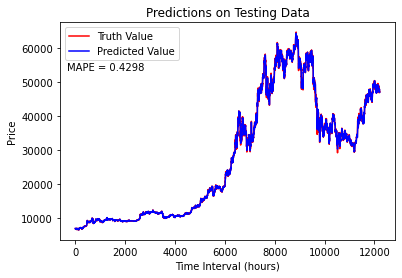

In [82]:
plt.plot(actualValues[-len(predictedValues):], color = 'red', label = 'Truth Value')
plt.plot(predictedValues, color = 'blue', label = 'Predicted Value')
plt.text(-350,53500,'MAPE = '+str(round(mape(actualValues[-len(predictedValues):], predictedValues),4)))
plt.title('Predictions on Testing Data')
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

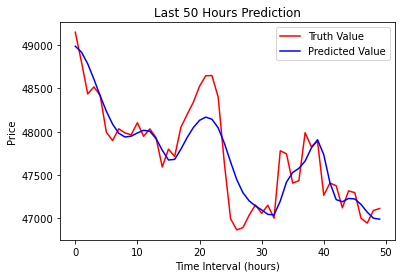

In [83]:
frm=-50
plt.plot(actualValues[frm:], color = 'red', label = 'Truth Value')
plt.plot(predictedValues[frm:], color = 'blue', label = 'Predicted Value') 
plt.title('Last {} Hours Prediction'.format(-frm))
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [84]:
actual = [actualValues[:len(trainingValues)], actualValues[-len(predictedValues):]]
predicted = [trainingValues, predictedValues]

for actual1, predicted1 in zip(actual, predicted):
    actual_delta= []
    predicted_delta = []
    correct_long = 0
    incorrect_long = 0
    correct_short = 0
    incorrect_short = 0

    for i in range(len(actual1) - 1):
        a_delta1 = (actual1[i + 1] - actual1[i]) / actual1[i + 1]
        p_delta1 = (predicted1[i + 1] - predicted1[i]) / predicted1[i + 1]

        if p_delta1 > 0 and a_delta1 > 0:
            correct_long += 1

        if p_delta1 > 0 > a_delta1:
            incorrect_long += 1

        if p_delta1 < 0 and a_delta1 < 0:
            correct_short += 1

        if p_delta1 < 0 < a_delta1:
            incorrect_short += 1

    long_p=correct_long/(correct_long+incorrect_long)*100
    short_p=correct_short/(correct_short+incorrect_short)*100
    total_correct= (correct_long+correct_short)/(correct_long+incorrect_long+correct_short+incorrect_short)*100
    print('long =', round(long_p,4))
    print('short =', round(short_p,4))
    print('total =', round(total_correct,4))
    print()

long = 63.1012
short = 60.613
total = 61.9136

long = 63.5002
short = 61.1169
total = 62.3698

